# Loading Data

In [1]:
from numbers import Number
from collections import defaultdict

import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

import sina.datastores.sql as sina_sql
import sina.utils
from sina.datastore import create_datastore
from sina.visualization import Visualizer
from sina.model import Record, generate_record_from_json
import math
import statistics
import numpy as np
import os
import sys


if sys.argv[1]=='-f': # Not sure why this returns '-f' if no arguments are passed?
    spec_root = ''
    %matplotlib notebook
else:
    spec_root = sys.argv[1] # Modify path for Python script since this is running within its own step

# Ensembles Initialization
database = os.path.join(spec_root,'../04_manage_data/data/ensembles_output.sqlite')
target_type = "csv_rec"
datastore = create_datastore(database)
recs = datastore.records
vis = Visualizer(datastore)
print("Sina is ready!")

# Baseline Initialization
database_baseline = os.path.join(spec_root,'../01_baseline_simulation/baseline/data/baseline_output.sqlite')
datastore_baseline = create_datastore(database_baseline)
recs_baseline = datastore_baseline.records
group_id = '47bcda'
val = recs_baseline.get(group_id+'_0')
print(val.data.keys()) # since there are no embedded keys we can just use this
#print(val.curve_sets) # no curve sets

x_true = val.data['x_pos']['value']
y_true = val.data['y_pos']['value']
z_true = val.data['z_pos']['value']
time_true = val.data['time']['value']

# Numerical Resolution Initialization
database_num_res = os.path.join(spec_root,'../01_baseline_simulation/num_res/data/num_res_output.sqlite')
datastore_num_res = create_datastore(database_num_res)
recs_num_res = datastore_num_res.records

Sina is ready!
dict_keys(['x_pos_initial', 'y_pos_initial', 'z_pos_initial', 'x_vel_initial', 'y_vel_initial', 'z_vel_initial', 'gravity', 'box_side_length', 'group_id', 'time', 'x_pos', 'y_pos', 'z_pos', 'x_pos_final', 'y_pos_final', 'z_pos_final', 'x_vel_final', 'y_vel_final', 'z_vel_final', 'num_bounces', 'x_rmse', 'x_diff', 'y_rmse', 'y_diff', 'z_rmse', 'z_diff'])


# Adding Data to Records

In [ ]:
mean_rec = Record(id= "mean", type="summary")
recs.delete("mean")

x_temp = []
y_temp = []
z_temp = []

x_mean = []
y_mean = []
z_mean = []
x_std = []
y_std = []
z_std = []

for i , t in enumerate(time_true):
    
    for rec in recs.get_all():

        x_pred = rec.data['x_pos']['value'][i]
        y_pred = rec.data['y_pos']['value'][i]
        z_pred = rec.data['z_pos']['value'][i]

        x_temp.append(x_pred)
        y_temp.append(y_pred)
        z_temp.append(z_pred)
            
        
    x_mean.append(statistics.mean(x_temp))
    y_mean.append(statistics.mean(y_temp))
    z_mean.append(statistics.mean(z_temp))
    x_std.append(statistics.stdev(x_temp))
    y_std.append(statistics.stdev(y_temp))
    z_std.append(statistics.stdev(z_temp))
    
    x_temp = []
    y_temp = []
    z_temp = []

mean_rec.add_data('time',time_true)
mean_rec.add_data('x_pos_mean',x_mean)
mean_rec.add_data('y_pos_mean',y_mean)
mean_rec.add_data('z_pos_mean',z_mean)
mean_rec.add_data('x_pos_std',x_std)
mean_rec.add_data('y_pos_std',y_std)
mean_rec.add_data('z_pos_std',z_std)    

mean_rec.add_data('x_pos_mean_plus_std', [ x_mean[i] + x_std[i] for i in range (len (time_true))])
mean_rec.add_data('y_pos_mean_plus_std', [ y_mean[i] + y_std[i] for i in range (len (time_true))])
mean_rec.add_data('z_pos_mean_plus_std', [ z_mean[i] + z_std[i] for i in range (len (time_true))])
mean_rec.add_data('x_pos_mean_minus_std', [ x_mean[i] - x_std[i] for i in range (len (time_true))])
mean_rec.add_data('y_pos_mean_minus_std', [ y_mean[i] - y_std[i] for i in range (len (time_true))])
mean_rec.add_data('z_pos_mean_minus_std', [ z_mean[i] - z_std[i] for i in range (len (time_true))])

mean_rec.add_data('x_pos_mean_plus_2std', [ x_mean[i] + 2*x_std[i] for i in range (len (time_true))])
mean_rec.add_data('y_pos_mean_plus_2std', [ y_mean[i] + 2*y_std[i] for i in range (len (time_true))])
mean_rec.add_data('z_pos_mean_plus_2std', [ z_mean[i] + 2*z_std[i] for i in range (len (time_true))])
mean_rec.add_data('x_pos_mean_minus_2std', [ x_mean[i] - 2*x_std[i] for i in range (len (time_true))])
mean_rec.add_data('y_pos_mean_minus_2std', [ y_mean[i] - 2*y_std[i] for i in range (len (time_true))])
mean_rec.add_data('z_pos_mean_minus_2std', [ z_mean[i] - 2*z_std[i] for i in range (len (time_true))])

recs.insert(mean_rec) # need to update or else won't save!!!!!    

# Plotting Options

In [2]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
scalars= ["x_pos_final", "y_pos_final", "z_pos_final"]
parameters = ['x_pos_initial', 'y_pos_initial', 'z_pos_initial', 'x_vel_initial', 'y_vel_initial', 'z_vel_initial']
convergence=[1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
n_bins = int(math.sqrt(convergence[-1]))

# QoI transient data with uncertainty bounds

<IPython.core.display.Javascript object>


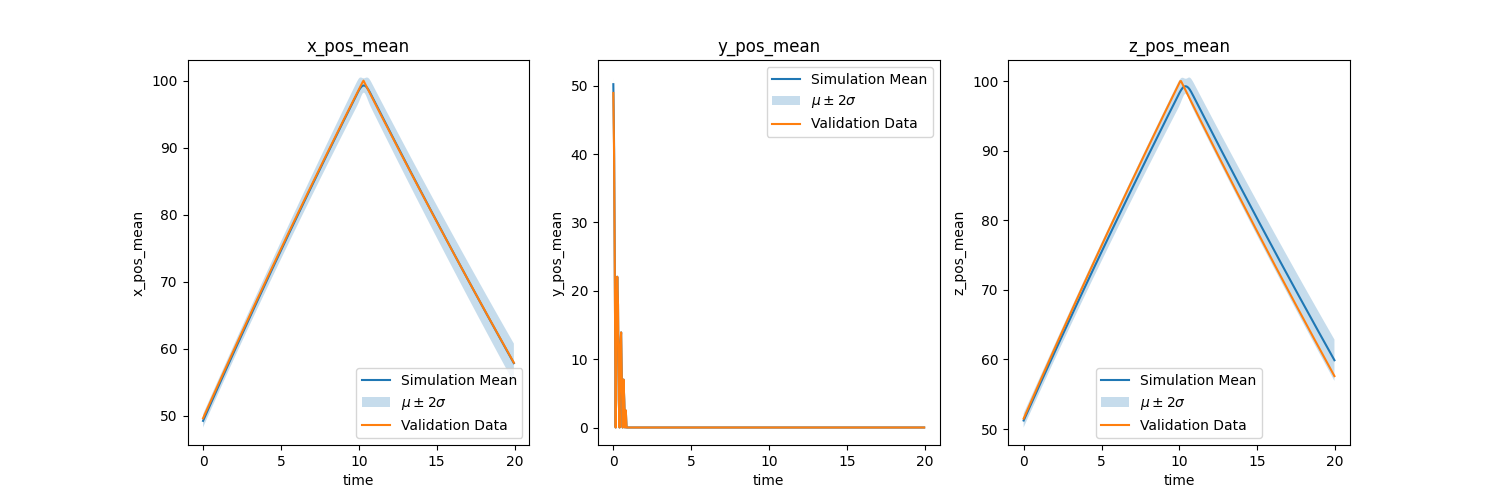

In [4]:
# Gathering Data

mean = recs.get('mean')
time = mean.data['time']['value']
x_pos_mean_plus_2std = mean.data['x_pos_mean_plus_2std']['value']
y_pos_mean_plus_2std = mean.data['y_pos_mean_plus_2std']['value']
z_pos_mean_plus_2std = mean.data['z_pos_mean_plus_2std']['value']

x_pos_mean_minus_2std = mean.data['x_pos_mean_minus_2std']['value']
y_pos_mean_minus_2std = mean.data['y_pos_mean_minus_2std']['value']
z_pos_mean_minus_2std = mean.data['z_pos_mean_minus_2std']['value']

# Plotting

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

_ = vis.create_line_plot(fig=fig, ax=ax[0],x="time", y="x_pos_mean", title = "{y_name}", id_pool=['mean'])
_ = vis.create_line_plot(fig=fig, ax=ax[1],x="time", y="y_pos_mean", title = "{y_name}", id_pool=['mean'])
_ = vis.create_line_plot(fig=fig, ax=ax[2],x="time", y="z_pos_mean", title = "{y_name}", id_pool=['mean'])

ax[0].fill_between(time,x_pos_mean_plus_2std,x_pos_mean_minus_2std, alpha=0.25)
ax[1].fill_between(time,y_pos_mean_plus_2std,y_pos_mean_minus_2std, alpha=0.25)
ax[2].fill_between(time,z_pos_mean_plus_2std,z_pos_mean_minus_2std, alpha=0.25)

ax[0].plot(time_true, x_true)
ax[1].plot(time_true, y_true)
ax[2].plot(time_true, z_true)

ax[0].legend(labels=['Simulation Mean','$\mu \pm 2 \sigma$','Validation Data'])
ax[1].legend(labels=['Simulation Mean','$\mu \pm 2 \sigma$','Validation Data'])
ax[2].legend(labels=['Simulation Mean','$\mu \pm 2 \sigma$','Validation Data'])

fig.savefig(os.path.join(spec_root,"../05_post-process_data/images/QoIs_u_input.png"))

# QoI point data violin and box plots

<IPython.core.display.Javascript object>


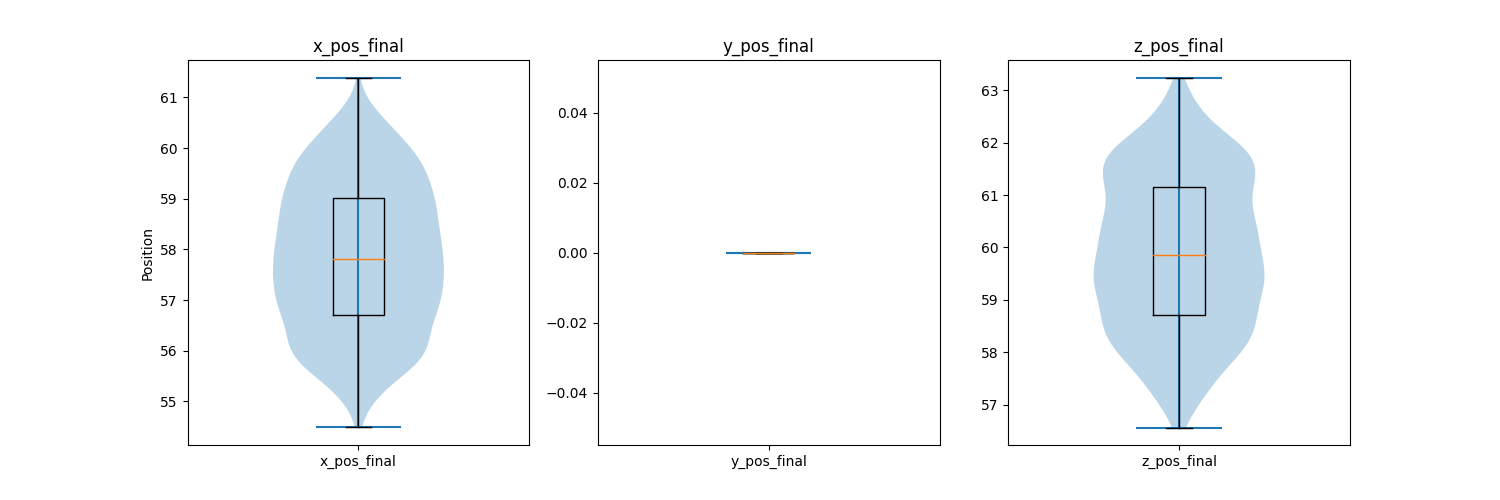

In [5]:
# Gathering Data 

final_data = recs.get_data(scalars)

x_pos_final = [x["x_pos_final"]["value"] for x in final_data.values()]
y_pos_final = [x["y_pos_final"]["value"] for x in final_data.values()]
z_pos_final = [x["z_pos_final"]["value"] for x in final_data.values()]

# Plotting

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

ax[0].violinplot(x_pos_final)
ax[0].boxplot(x_pos_final)
ax[1].violinplot(y_pos_final)
ax[1].boxplot(y_pos_final)
ax[2].violinplot(z_pos_final)
ax[2].boxplot(z_pos_final)

ax[0].set_title("x_pos_final")
ax[0].set_ylabel("Position")
ax[0].set_xticklabels(["x_pos_final"])

ax[1].set_title("y_pos_final")
ax[1].set_xticklabels(["y_pos_final"])

ax[2].set_title("z_pos_final")
ax[2].set_xticklabels(["z_pos_final"])

fig.savefig(os.path.join(spec_root,"../05_post-process_data/images/QoIs_violin_box.png"))

# QoI point data violin and box convergence plots

<IPython.core.display.Javascript object>


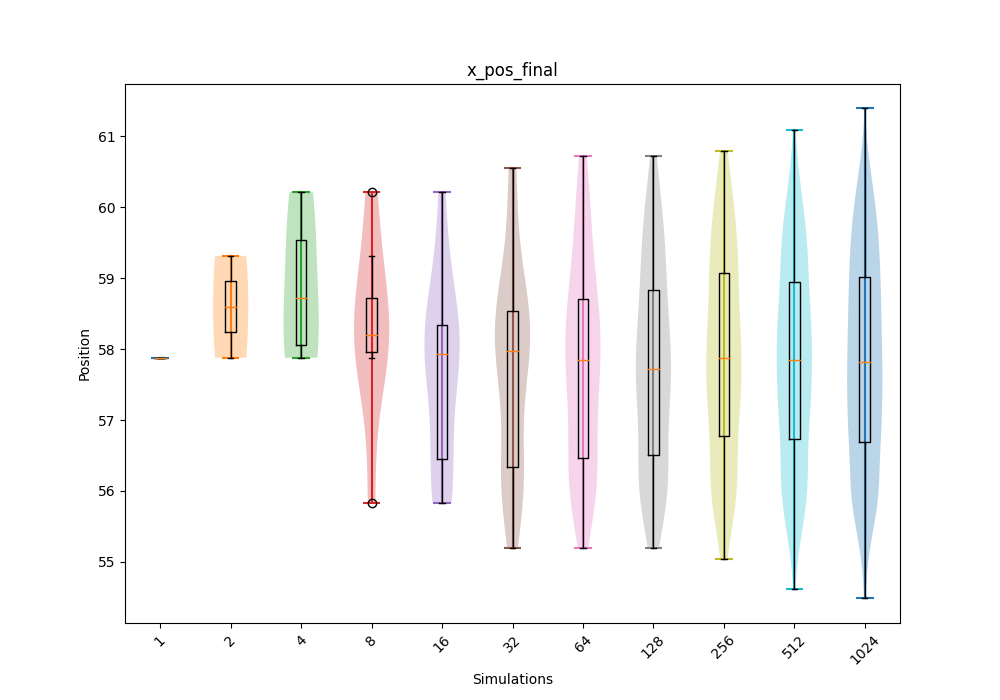

<IPython.core.display.Javascript object>


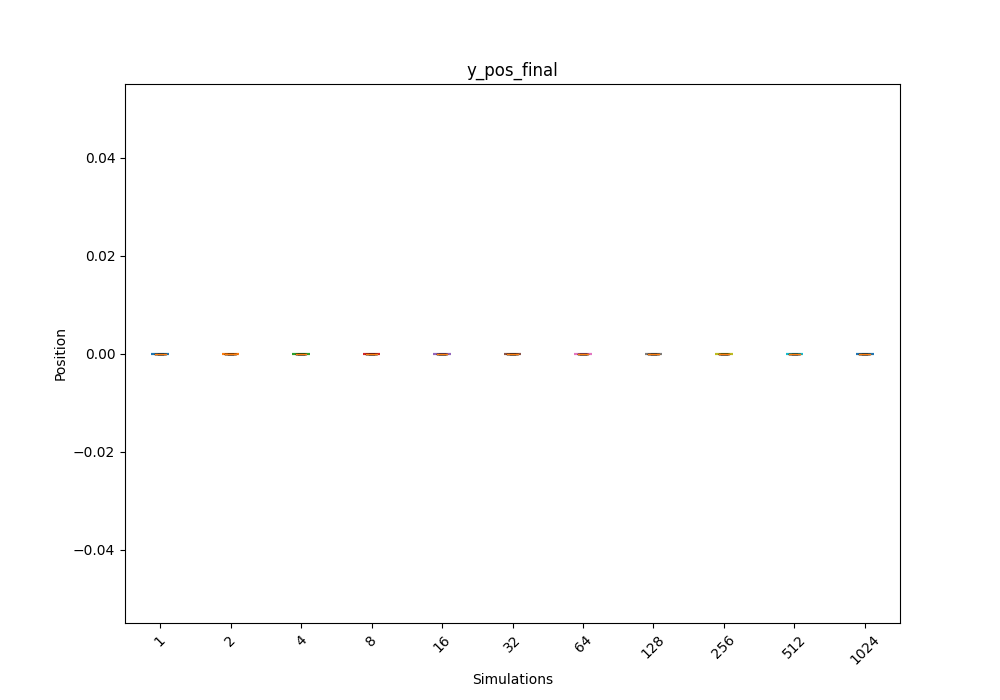

<IPython.core.display.Javascript object>


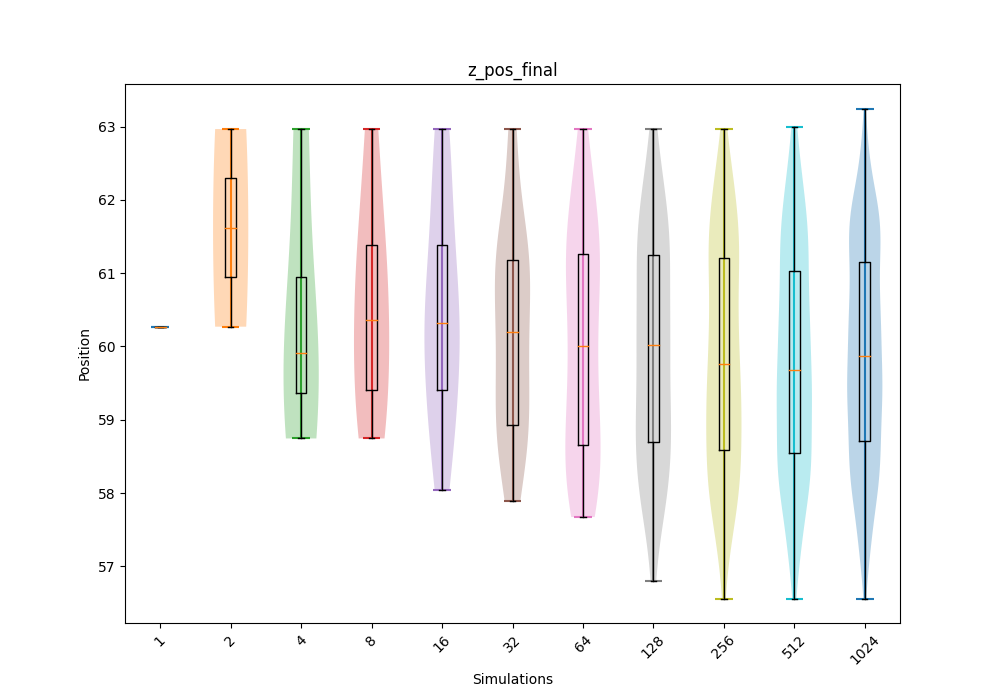

In [6]:
for scalar in scalars:
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))  
        
    for i, runs in enumerate(convergence):
        
        convergence_ids = [ group_id+"_"+str(x+1) for x in range(runs)] # We can do this because IDs have the run number

        if runs == convergence[-1]: # Will error if all ids are present
            final_data = recs.get_data(scalars)
        else:
            final_data = recs.get_data(scalars,id_list=convergence_ids)

        scalar_values = [x[scalar]["value"] for x in final_data.values()]

        ax.violinplot(scalar_values, positions = [i])
        ax.boxplot(scalar_values, positions = [i])

    ax.set_title(scalar)
    ax.set_xlabel("Simulations")
    ax.set_ylabel("Position")
    ax.set_xticklabels(convergence, rotation = 45)

    fig.savefig(os.path.join(spec_root,f"../05_post-process_data/images/QoIs_{scalar}_violin_box_convergence.png"))

# QoI point data PDF and CDF plots

<IPython.core.display.Javascript object>


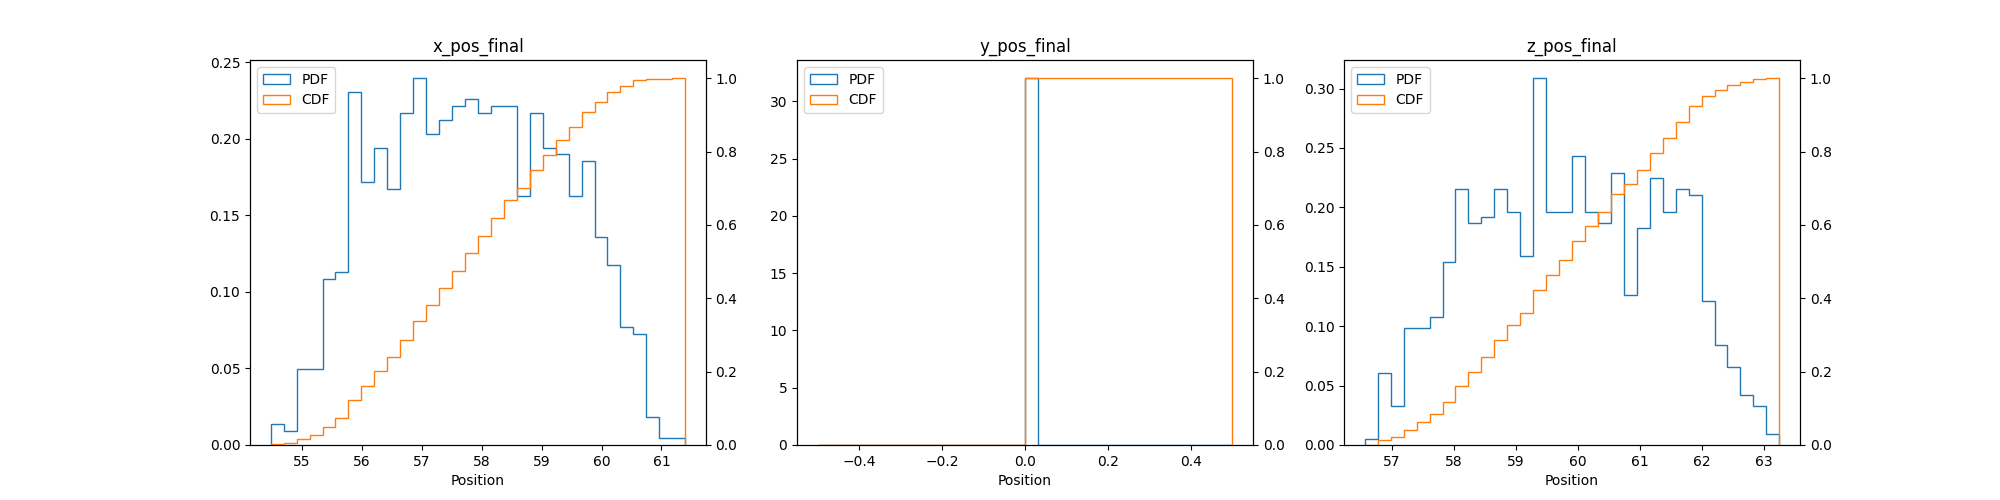

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

ax1 = []
ax1.append(ax[0].twinx())
ax1.append(ax[1].twinx())
ax1.append(ax[2].twinx())

# x
ax[0].hist(x_pos_final, bins=n_bins, histtype='step', density=True, label = 'PDF')
ax1[0].hist(x_pos_final, bins=n_bins, histtype='step', density=True, cumulative=True, color = colors[1], label = 'CDF')

ax[0].set_title("x_pos_final")
ax[0].set_xlabel("Position")
lines, labels = ax[0].get_legend_handles_labels()
lines2, labels2 = ax1[0].get_legend_handles_labels()
ax[0].legend(lines + lines2, labels + labels2, loc='upper left')

# y
ax[1].hist(y_pos_final, bins=n_bins, histtype='step', density=True)
ax1[1].hist(y_pos_final, bins=n_bins, histtype='step', density=True, cumulative=True, color = colors[1])

ax[1].set_title("y_pos_final")
ax[1].set_xlabel("Position")
ax[1].legend(lines + lines2, labels + labels2, loc='upper left')

# z
ax[2].hist(z_pos_final, bins=n_bins, histtype='step', density=True)
ax1[2].hist(z_pos_final, bins=n_bins, histtype='step', density=True, cumulative=True, color = colors[1])

ax[2].set_title("z_pos_final")
ax[2].set_xlabel("Position")
ax[2].legend(lines + lines2, labels + labels2, loc='upper left')

fig.savefig(os.path.join(spec_root,"../05_post-process_data/images/QoIs_pdf_cdf.png"))

# QoI point data PDF and CDF convergence plots

<IPython.core.display.Javascript object>


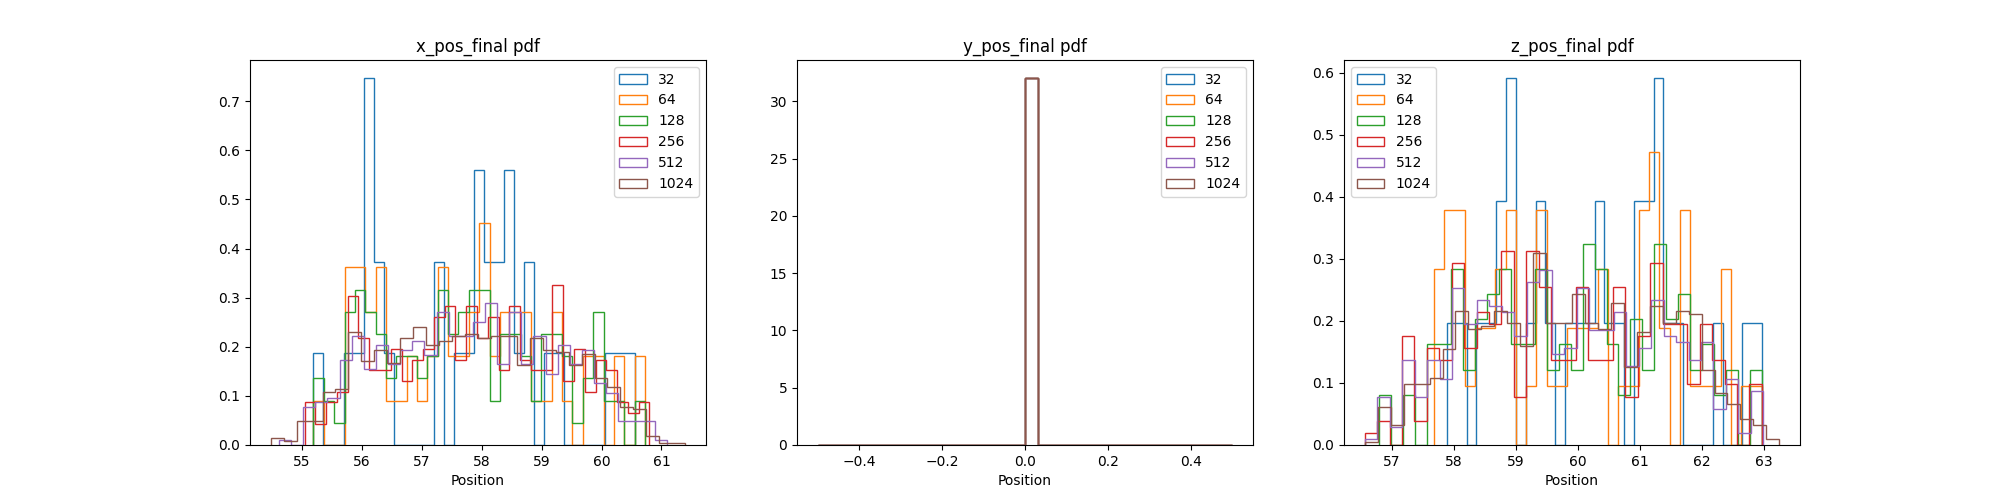

<IPython.core.display.Javascript object>


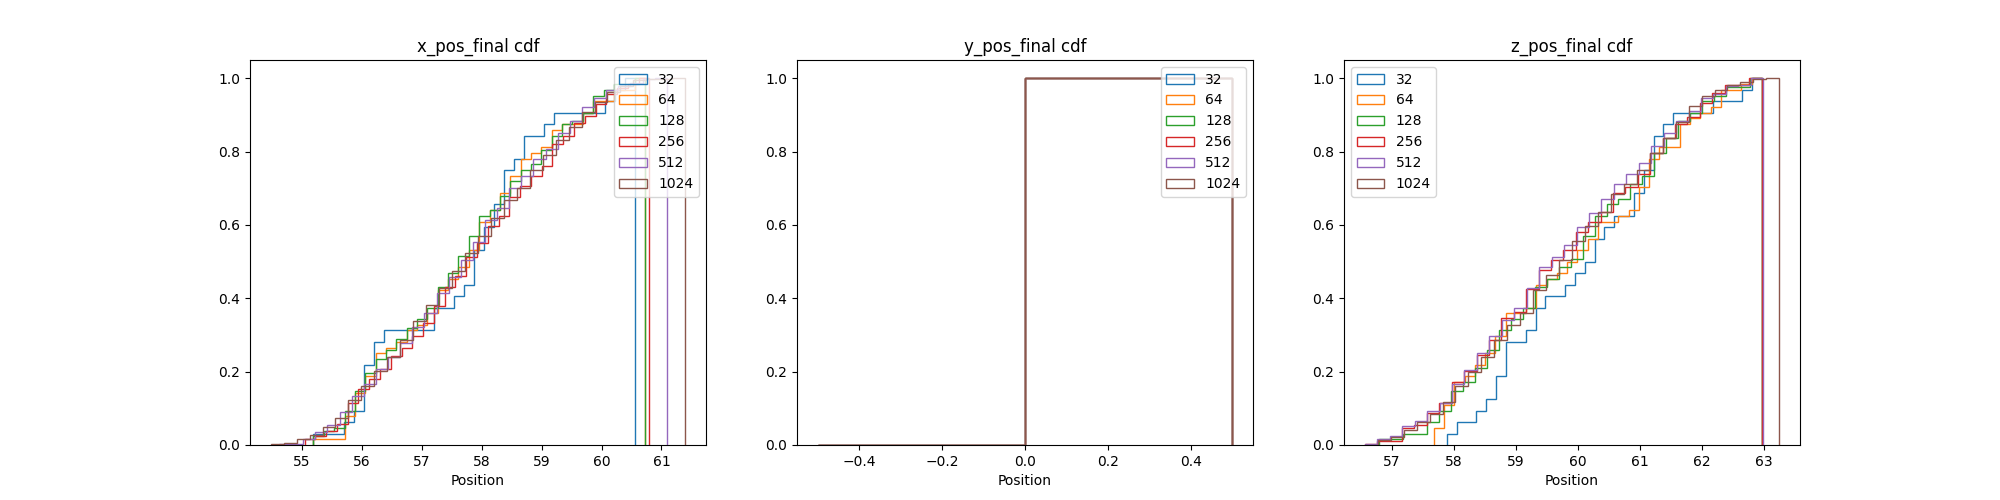

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
fig1, ax1 = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))


for i, runs in enumerate(convergence[5:]): # Depending on number of runs, can obscure the rest 
    
    convergence_ids = [ group_id+"_"+str(x+1) for x in range(runs)] # We can do this because IDs have the run number
  
    if runs == convergence[-1]: # Will error if all ids are present
        final_data = recs.get_data(scalars)
    else:
        final_data = recs.get_data(scalars,id_list=convergence_ids)

    x_pos_final = [x["x_pos_final"]["value"] for x in final_data.values()]
    y_pos_final = [x["y_pos_final"]["value"] for x in final_data.values()]
    z_pos_final = [x["z_pos_final"]["value"] for x in final_data.values()]

    ax[0].hist(x_pos_final, bins=n_bins, histtype='step', density=True, label = runs)
    ax[1].hist(y_pos_final, bins=n_bins, histtype='step', density=True, label = runs)
    ax[2].hist(z_pos_final, bins=n_bins, histtype='step', density=True, label = runs)    
    
    ax1[0].hist(x_pos_final, bins=n_bins, histtype='step', density=True, cumulative=True, label = runs)
    ax1[1].hist(y_pos_final, bins=n_bins, histtype='step', density=True, cumulative=True, label = runs)
    ax1[2].hist(z_pos_final, bins=n_bins, histtype='step', density=True, cumulative=True, label = runs)   
    
# x
ax[0].set_title("x_pos_final pdf")
ax[0].set_xlabel("Position")
ax[0].legend()

# y
ax[1].set_title("y_pos_final pdf")
ax[1].set_xlabel("Position")
ax[1].legend()

# z
ax[2].set_title("z_pos_final pdf")
ax[2].set_xlabel("Position")
ax[2].legend()

fig.savefig(os.path.join(spec_root,"../05_post-process_data/images/QoIs_pdf_convergence.png"))

# x
ax1[0].set_title("x_pos_final cdf")
ax1[0].set_xlabel("Position")
ax1[0].legend()

# y
ax1[1].set_title("y_pos_final cdf")
ax1[1].set_xlabel("Position")
ax1[1].legend()

# z
ax1[2].set_title("z_pos_final cdf")
ax1[2].set_xlabel("Position")
ax1[2].legend()

fig1.savefig(os.path.join(spec_root,"../05_post-process_data/images/QoIs_cdf_convergence.png"))

# QoI point data parameter correlation scatter plots

Negative correlation because bouncing off the wall quicker if your further out or faster

/g/g20/moreno45/Projects/WEAVE/weave_demos/ball_bounce/ball_bounce_demo_venv/lib/python3.7/site-packages/numpy/lib/function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/g/g20/moreno45/Projects/WEAVE/weave_demos/ball_bounce/ball_bounce_demo_venv/lib/python3.7/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/g/g20/moreno45/Projects/WEAVE/weave_demos/ball_bounce/ball_bounce_demo_venv/lib/python3.7/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/g/g20/moreno45/Projects/WEAVE/weave_demos/ball_bounce/ball_bounce_demo_venv/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/g/g20/moreno45/Projects/WEAVE/weave_demos/ball_bounce/ball_bounce_demo_venv/lib/python3.7/site-packages/nu

<IPython.core.display.Javascript object>


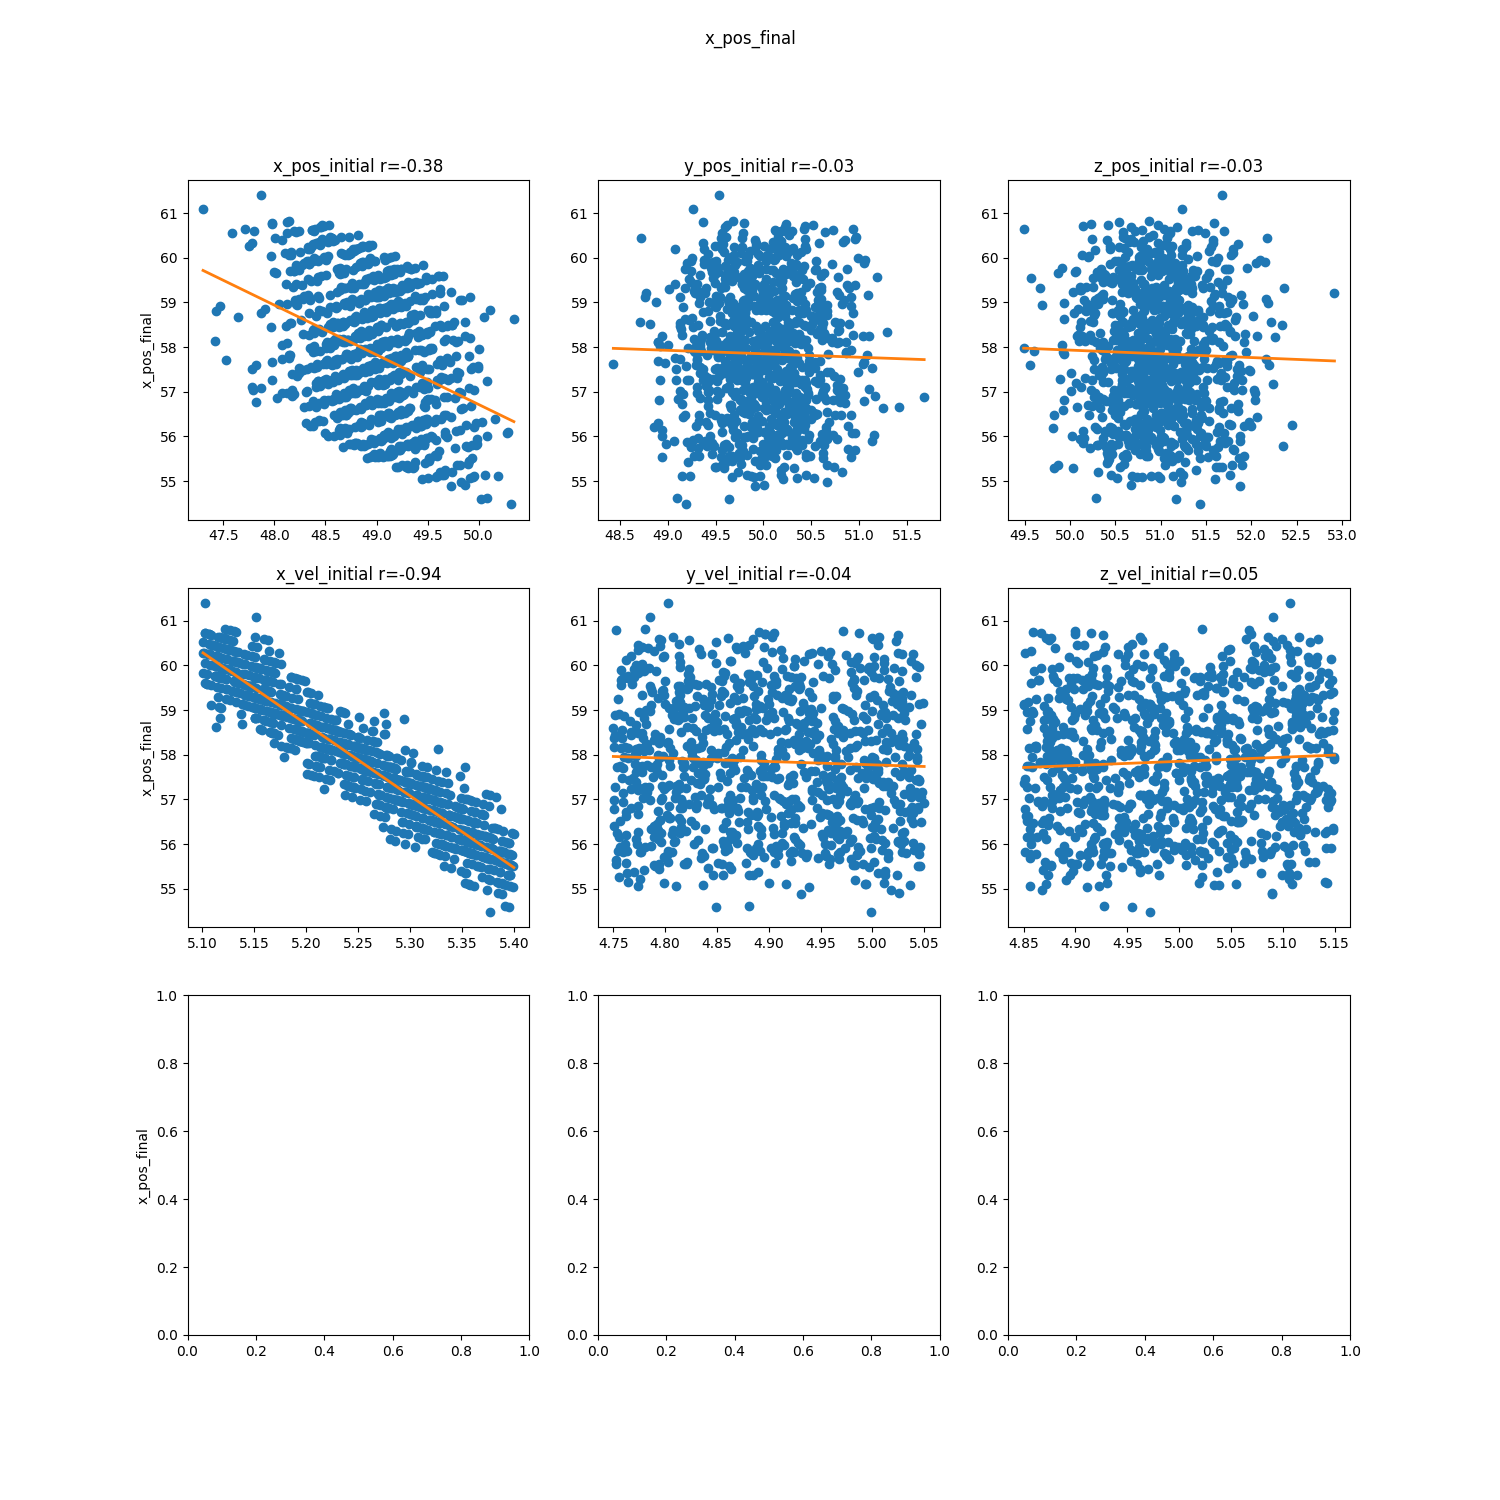

-1.1103746666136032 -0.3775001545795447
-0.07750370622175536 -0.025928373108229534
-0.08317224878082642 -0.02860036419238407
-16.059438707721963 -0.939474261697383
-0.7485480794972997 -0.044205099684280054
0.9248855585248748 0.05402461559166938


<IPython.core.display.Javascript object>


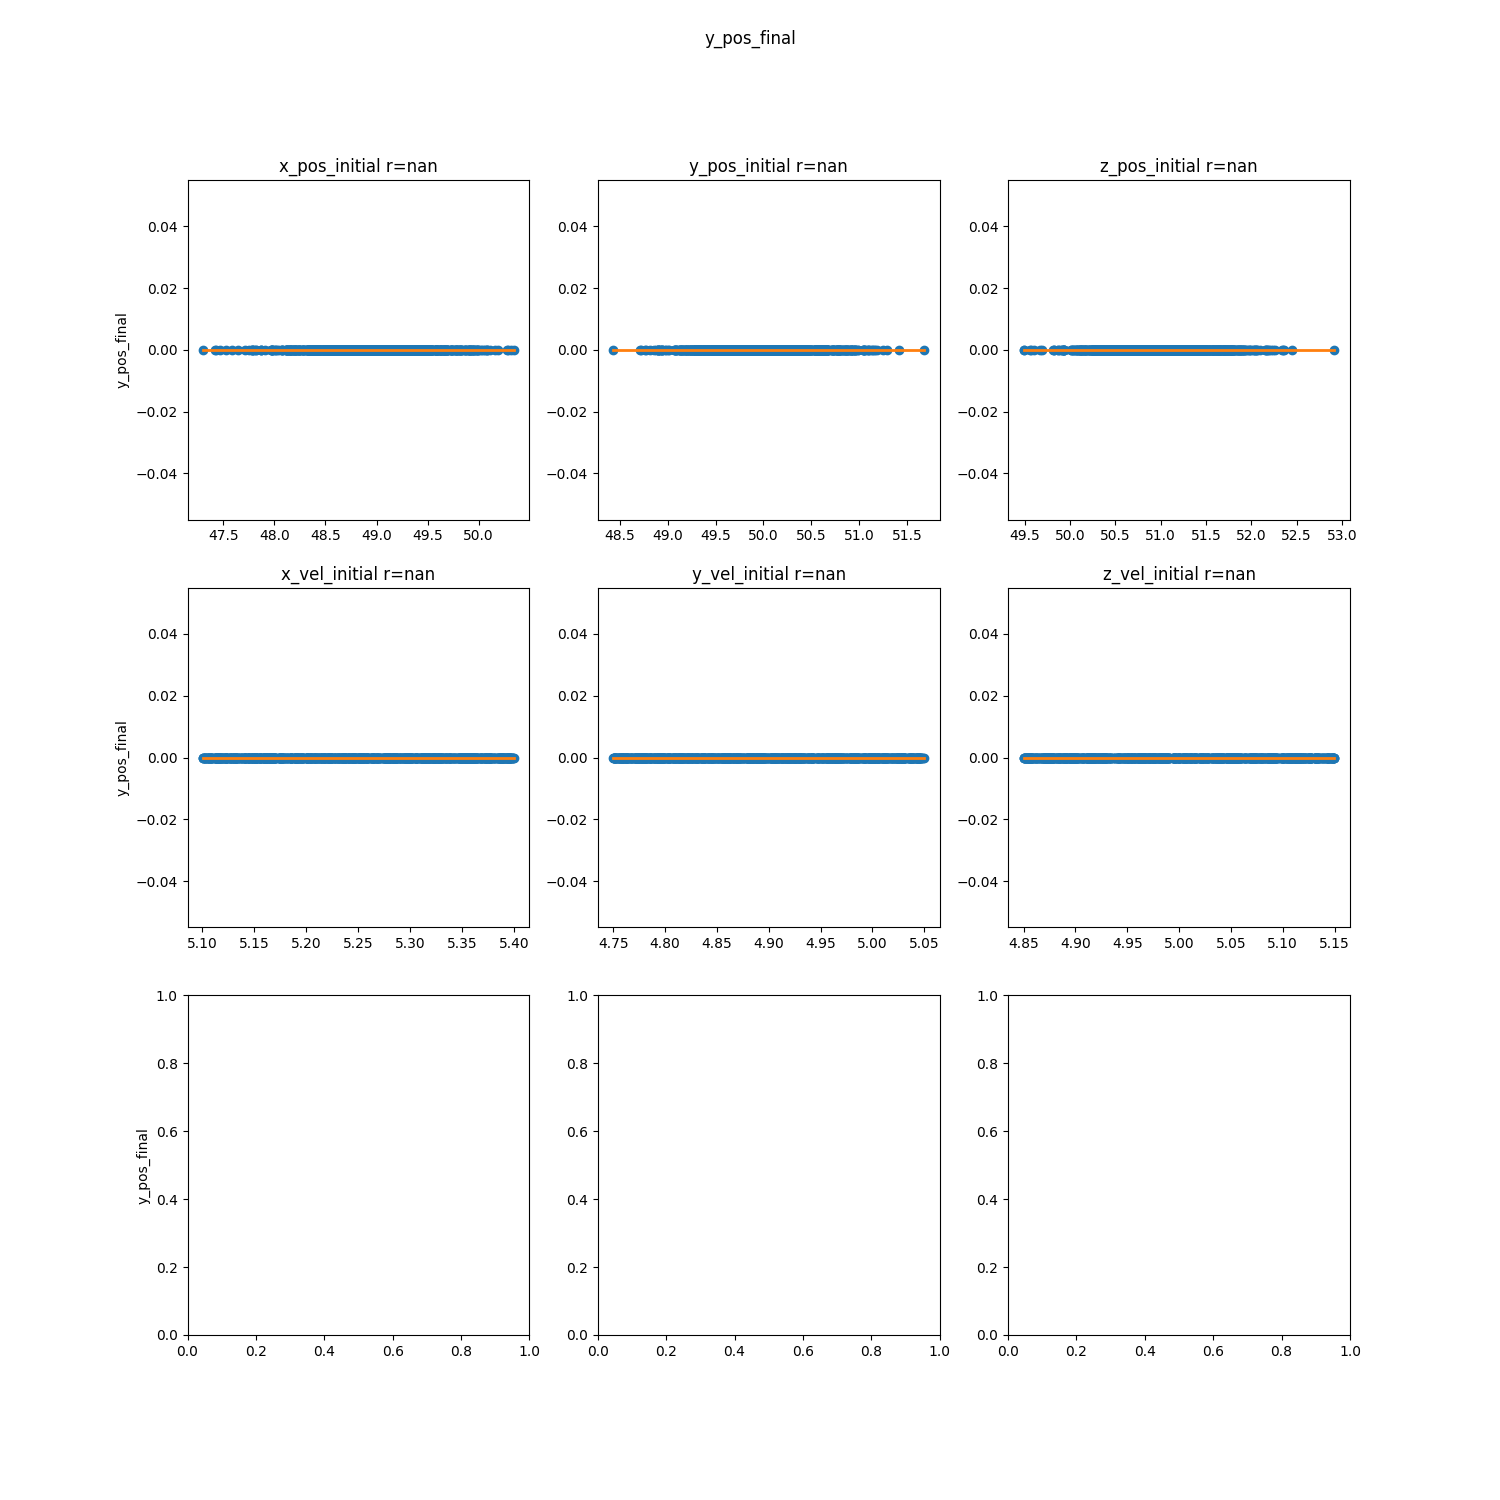

0.0 nan
0.0 nan
0.0 nan
0.0 nan
0.0 nan
0.0 nan


<IPython.core.display.Javascript object>


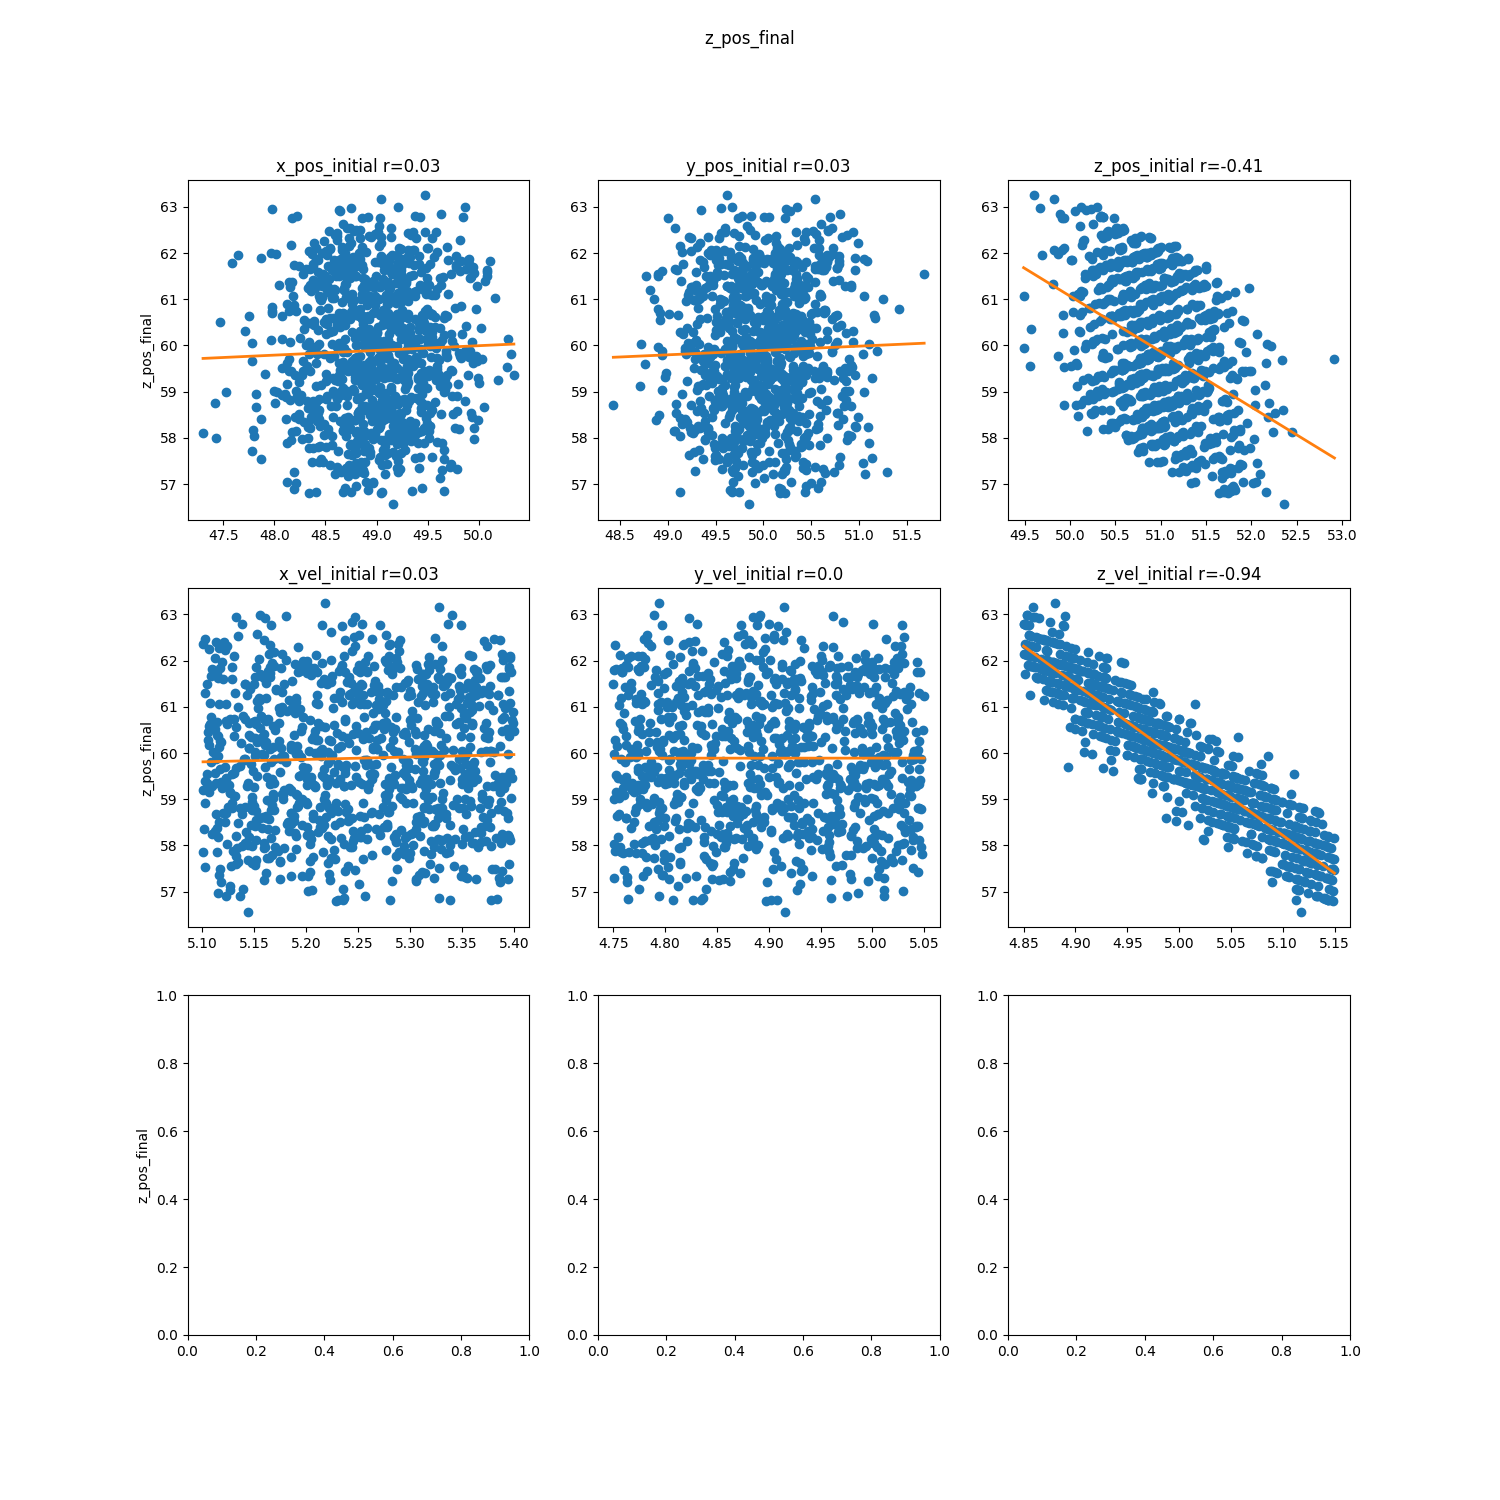

0.10198126560700899 0.0340535156435223
0.09391288022642975 0.030858294891316147
-1.200041358178619 -0.40530625060333836
0.5241206521751821 0.030114784877220344
0.0033347806260221576 0.00019342558174036874
-16.39485030598865 -0.9406002957133943


In [9]:
num_plts = len(parameters)
rows_cols = math.ceil(math.sqrt(num_plts))

all_scalars = scalars + parameters


corrcoefs = {} # Correlation Coefficient Dictionary that will be used in the next two cells

for i, runs in enumerate(convergence):
    
    convergence_ids = [ group_id+"_"+str(x+1) for x in range(runs)] # We can do this because IDs have the run number
    
    if runs == convergence[-1]: # will error if all ids are present
        final_data = recs.get_data(all_scalars)
    else:
        final_data = recs.get_data(all_scalars,id_list=convergence_ids)
        
    corrcoefs[runs] = {}
    
    for scalar in scalars:

        if runs == convergence[-1]: # Just plot the last set of simulations
            
            fig, ax = plt.subplots(nrows=rows_cols, ncols=rows_cols, figsize=(rows_cols*5, rows_cols*5))

            fig.suptitle(scalar)

            i=0
            j=0
            ax[j,i].set_ylabel(scalar)
        
        scalar_values = [x[scalar]["value"] for x in final_data.values()]
        
        corrcoefs[runs][scalar] = {}
        
        for parameter in parameters:

            parameter_values = [x[parameter]["value"] for x in final_data.values()]
 
            r = np.corrcoef(parameter_values, scalar_values)[0,1]
            corrcoefs[runs][scalar][parameter] = r
        
            if runs == convergence[-1]: # Just plot the last set of simulations  
                
                m, b = np.polyfit(parameter_values, scalar_values, 1)
                print(m,r)   
                x = np.linspace(min(parameter_values),max(parameter_values))
                y = m*x+b

#                 slope, intercept, r, p, se = stats.linregress(x, y)

                ax[j,i].scatter(parameter_values, scalar_values)
                ax[j,i].plot(x, y, color = colors[1], linewidth=2.0)
                ax[j,i].set_title(f"{parameter} r={round(r,2)}")

                if i == rows_cols-1: # Cycling through subplots
                    
                    i = 0
                    j += 1
                    ax[j,i].set_ylabel(scalar)
                    
                else:
                    
                    i += 1
                    
        if runs == convergence[-1]: # Just plot the last set of simulations
            fig.savefig(os.path.join(spec_root,f"../05_post-process_data/images/QoIs_{scalar}_correlation.png"))

# QoI point data parameter correlation heatmaps

<IPython.core.display.Javascript object>


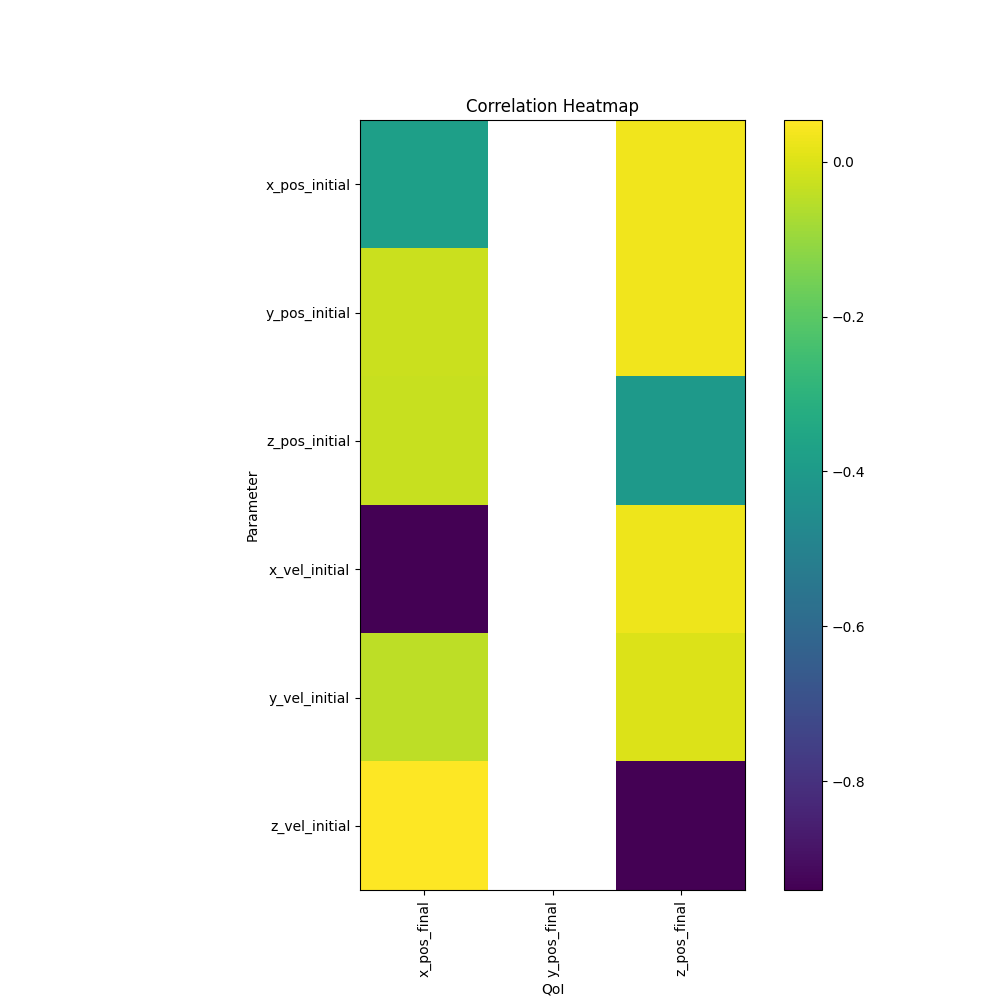

In [10]:
i=0
j=0

cc_matrix=np.zeros((len(parameters),len(scalars)))

for scalar in scalars:
    
    for parameter in parameters:

        cc_matrix[i,j] = corrcoefs[convergence[-1]][scalar][parameter]
        i+=1
        
    i=0
    j+=1

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
im = ax.imshow(cc_matrix)
cbar = ax.figure.colorbar(im, ax=ax)

ax.set_title("Correlation Heatmap")

ax.set_xlabel("QoI")
ax.set_xticks(np.arange(len(scalars)))
ax.set_xticklabels(scalars, rotation=90, ha='center', minor=False)

ax.set_ylabel("Parameter")
ax.set_yticks(np.arange(len(parameters)))
ax.set_yticklabels(parameters, minor=False)

fig.savefig(os.path.join(spec_root,'../05_post-process_data/images/QoIs_correlation_heatmap'))

<IPython.core.display.Javascript object>


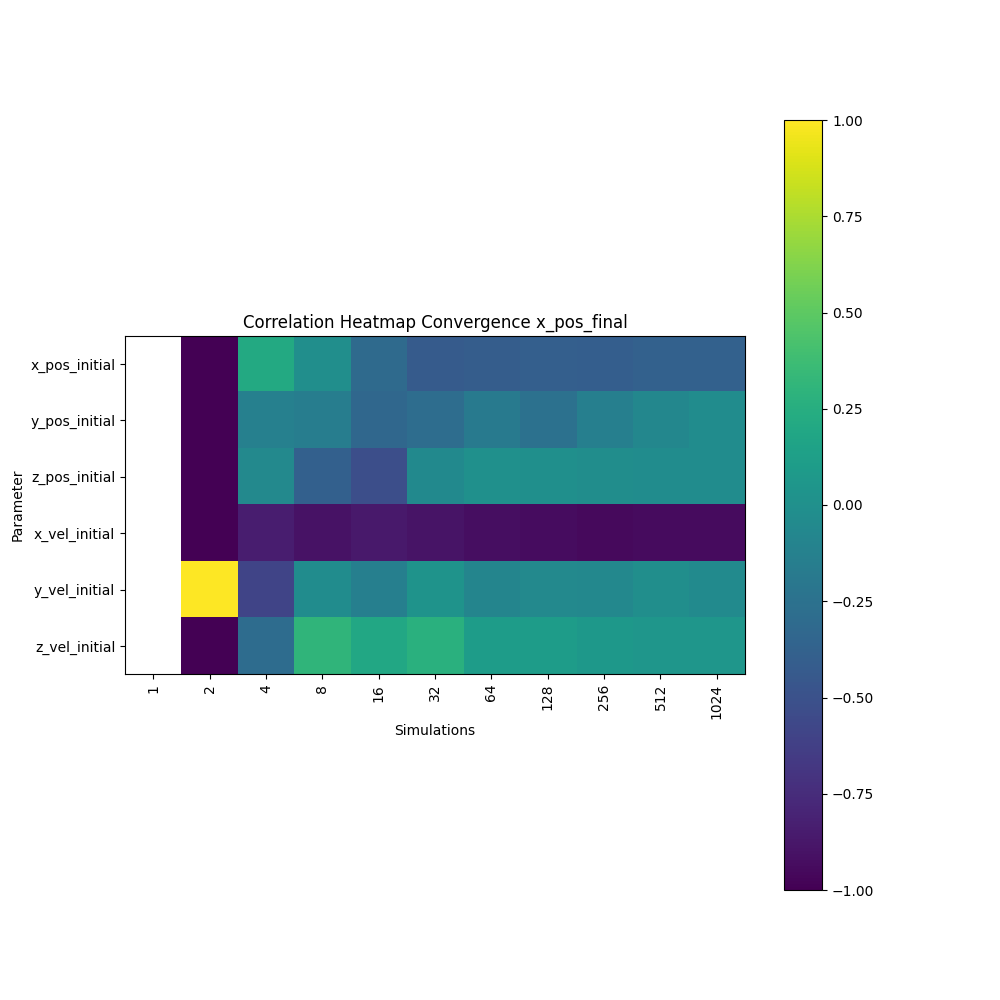

<IPython.core.display.Javascript object>


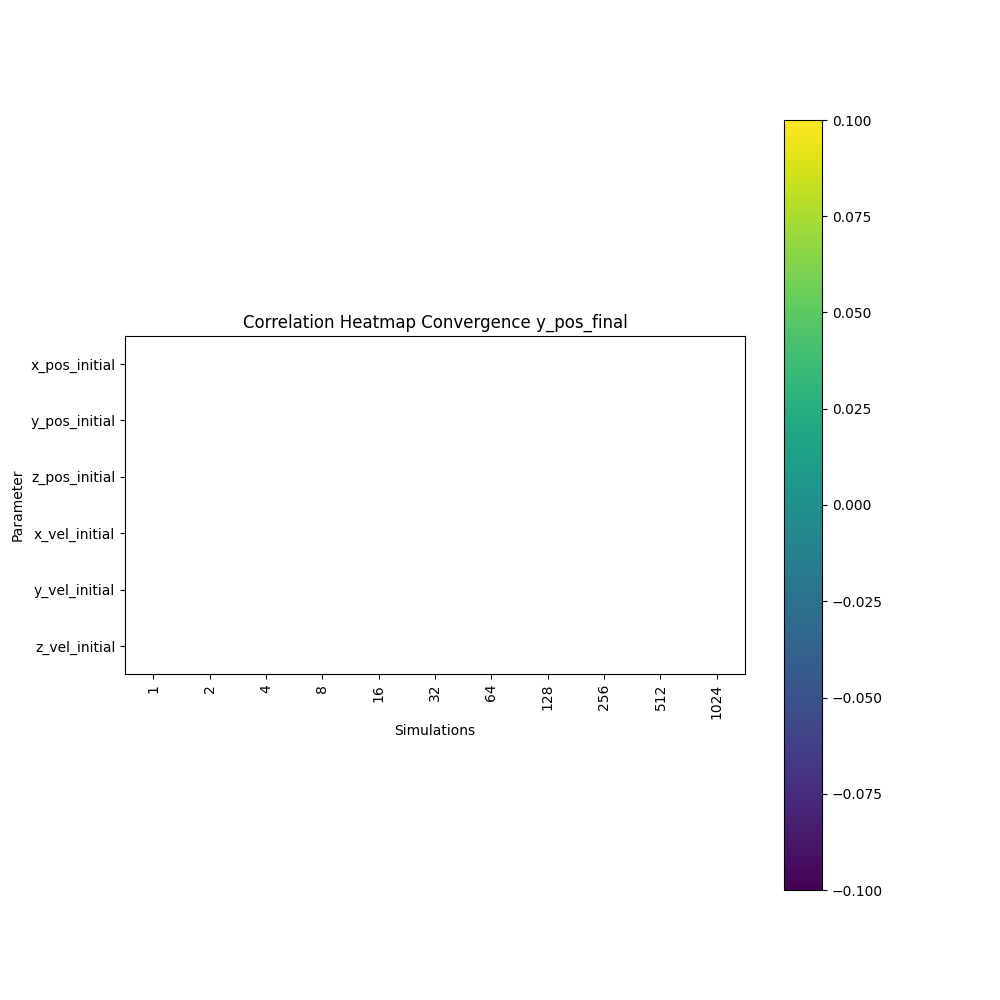

<IPython.core.display.Javascript object>


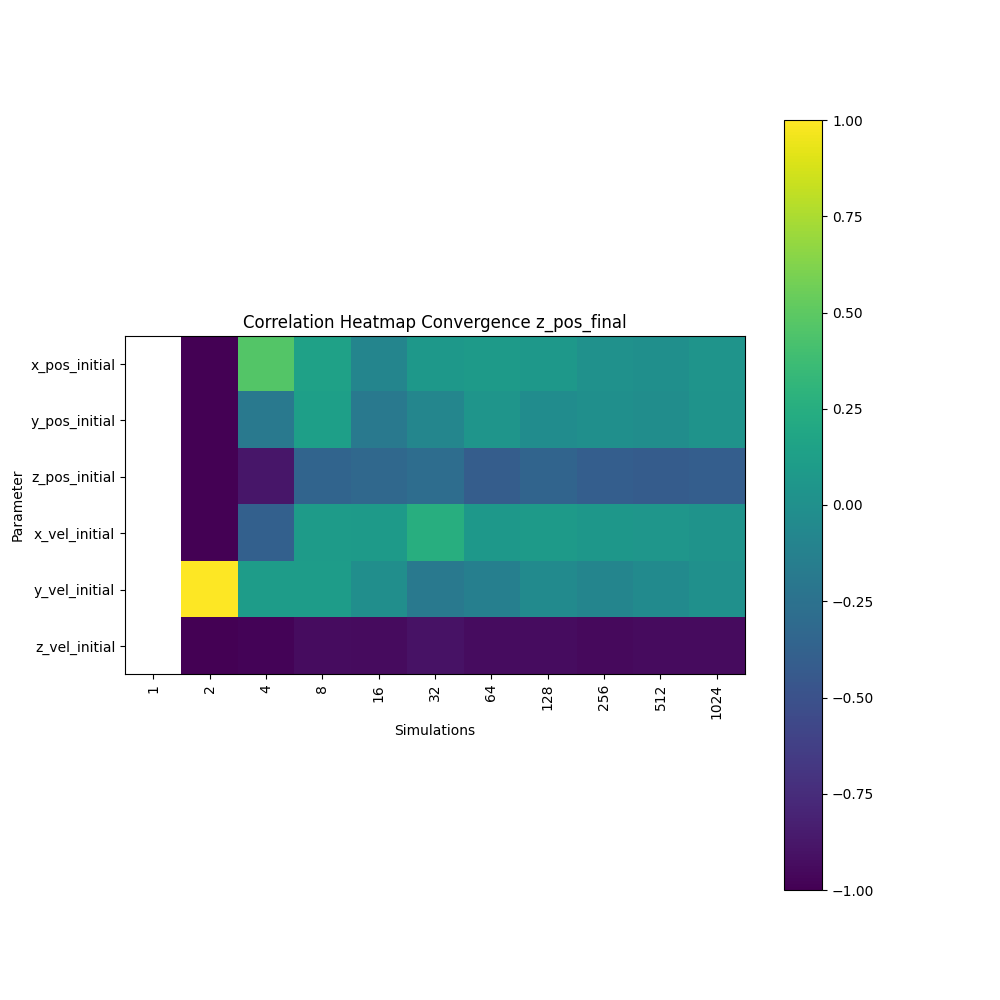

In [11]:
i=0
j=0

cc_matrix=np.zeros((len(parameters),len(convergence)))

for scalar in scalars:
    
    for runs in convergence: 
        
        for parameter in parameters:

            cc_matrix[i,j] = corrcoefs[runs][scalar][parameter]
            i+=1
            
        i=0
        j+=1
        
    i=0
    j=0
        
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
    im = ax.imshow(cc_matrix)
    cbar = ax.figure.colorbar(im, ax=ax)

    ax.set_title(f"Correlation Heatmap Convergence {scalar}")

    ax.set_xlabel("Simulations")
    ax.set_xticks(np.arange(len(convergence)))
    ax.set_xticklabels(convergence, rotation=90, ha='center', minor=False)

    ax.set_ylabel("Parameter")
    ax.set_yticks(np.arange(len(parameters)))
    ax.set_yticklabels(parameters, minor=False)

    fig.savefig(os.path.join(spec_root,f'../05_post-process_data/images/QoIs_{scalar}_correlation_heatmap_convergence'))

# Adding up the uncertainties

## Adding common timestep data to Ensembles

In [13]:
# Numerical Resolution
# Be sure to run 01_baseline_simulation/num_res/visualization_num_res.ipynb to acquire necessary data
mean_num_res = recs_num_res.get('mean')
time_num_res = mean_num_res.data['time_common']['value']

# Ensembles
mean = recs.get('mean')
time = mean.data['time']['value']
x_pos_mean = mean.data['x_pos_mean']['value']
y_pos_mean = mean.data['y_pos_mean']['value']
z_pos_mean = mean.data['z_pos_mean']['value']
x_pos_std = mean.data['x_pos_std']['value']
y_pos_std = mean.data['y_pos_std']['value']
z_pos_std = mean.data['z_pos_std']['value']

x_pos_mean_common = []
y_pos_mean_common = []
z_pos_mean_common = []
x_pos_std_common = []
y_pos_std_common = []
z_pos_std_common = []
time_common = []

for i, t in enumerate(time):
    
    for t2 in time_num_res:
        
        if t == t2:
            
            x_pos_mean_common.append(x_pos_mean[i])
            y_pos_mean_common.append(y_pos_mean[i])
            z_pos_mean_common.append(z_pos_mean[i])
            x_pos_std_common.append(x_pos_std[i])
            y_pos_std_common.append(y_pos_std[i])
            z_pos_std_common.append(z_pos_std[i])
            time_common.append(time[i])

mean.add_data('time_common',time_common)
mean.add_data('x_pos_mean_common',x_pos_mean_common)
mean.add_data('y_pos_mean_common',y_pos_mean_common)
mean.add_data('z_pos_mean_common',z_pos_mean_common)
mean.add_data('x_pos_std_common',x_pos_std_common)
mean.add_data('y_pos_std_common',y_pos_std_common)
mean.add_data('z_pos_std_common',z_pos_std_common)

recs.update(mean) # need to update or else won't save!!!!!

ValueError: Duplicate datum: "time_common" is already an entry in Record "mean".

## Calculating Validation Uncertainty

<IPython.core.display.Javascript object>


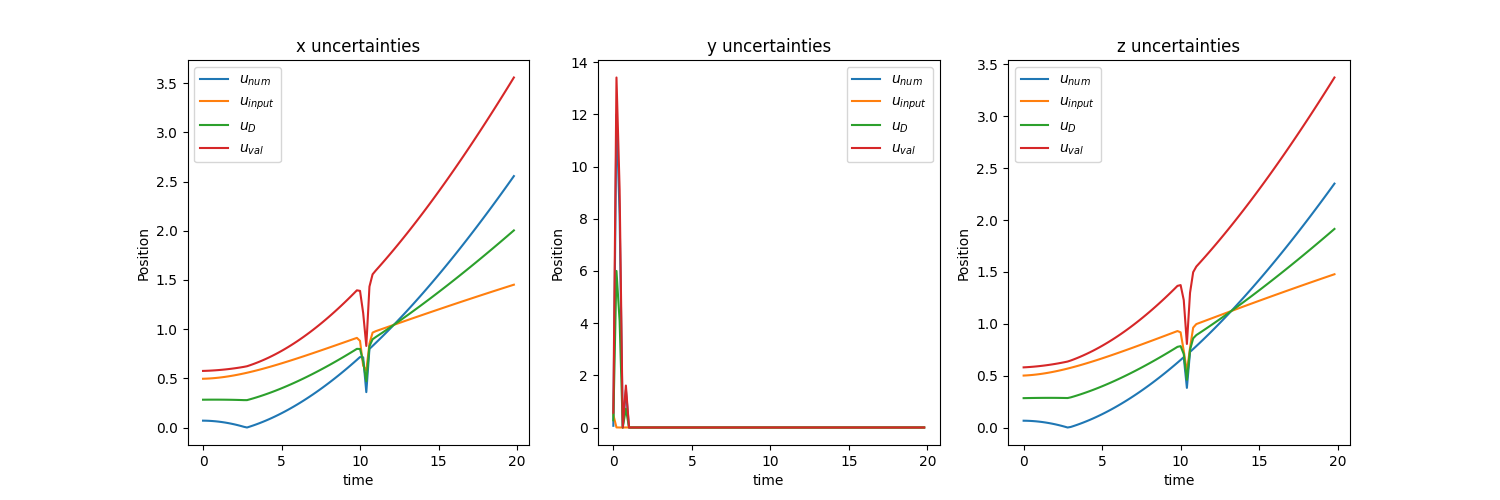

In [14]:
# Numerical Resolution: Numerical Uncertainty (u_num)
# Be sure to run 01_baseline_simulation/num_res/visualization_num_res.ipynb to acquire necessary data
x_pos_std_num_res = mean_num_res.data['x_pos_std']['value']
y_pos_std_num_res = mean_num_res.data['y_pos_std']['value']
z_pos_std_num_res = mean_num_res.data['z_pos_std']['value']

# Ensembles: Input Uncertainty (u_input)
x_pos_mean_common = mean.data['x_pos_mean_common']['value']
x_pos_mean_common = mean.data['x_pos_mean_common']['value']
y_pos_mean_common = mean.data['y_pos_mean_common']['value']
z_pos_mean_common = mean.data['z_pos_mean_common']['value']
x_pos_std_common = mean.data['x_pos_std_common']['value']
y_pos_std_common = mean.data['y_pos_std_common']['value']
z_pos_std_common = mean.data['z_pos_std_common']['value']

# Experiment: Experimental Uncertainty (u_D)
u_D_x = [statistics.mean([x,y]) for x, y in zip(x_pos_std_num_res,x_pos_std_common)]
u_D_y = [statistics.mean([x,y]) for x, y in zip(y_pos_std_num_res,y_pos_std_common)]
u_D_z = [statistics.mean([x,y]) for x, y in zip(z_pos_std_num_res,z_pos_std_common)]

# Validation Uncertainty (u_val)
u_val_x = np.sqrt(np.square(x_pos_std_num_res)+np.square(x_pos_std_common)+np.square(u_D_x))
u_val_y = np.sqrt(np.square(y_pos_std_num_res)+np.square(y_pos_std_common)+np.square(u_D_y))
u_val_z = np.sqrt(np.square(z_pos_std_num_res)+np.square(z_pos_std_common)+np.square(u_D_z))

# Plotting
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

ax[0].plot(time_common, x_pos_std_num_res, label = '$u_{num}$')
ax[1].plot(time_common, y_pos_std_num_res, label = '$u_{num}$')
ax[2].plot(time_common, z_pos_std_num_res, label = '$u_{num}$')

ax[0].plot(time_common, x_pos_std_common, label = '$u_{input}$')
ax[1].plot(time_common, y_pos_std_common, label = '$u_{input}$')
ax[2].plot(time_common, z_pos_std_common, label = '$u_{input}$')

ax[0].plot(time_common, u_D_x, label = '$u_{D}$')
ax[1].plot(time_common, u_D_y, label = '$u_{D}$')
ax[2].plot(time_common, u_D_z, label = '$u_{D}$')

ax[0].plot(time_common, u_val_x, label = '$u_{val}$')
ax[1].plot(time_common, u_val_y, label = '$u_{val}$')
ax[2].plot(time_common, u_val_z, label = '$u_{val}$')

ax[0].set_title("x uncertainties")
ax[1].set_title("y uncertainties")
ax[2].set_title("z uncertainties")

ax[0].set_xlabel("time")
ax[1].set_xlabel("time")
ax[2].set_xlabel("time")

ax[0].set_ylabel("Position")
ax[1].set_ylabel("Position")
ax[2].set_ylabel("Position")

ax[0].legend()
ax[1].legend()
ax[2].legend()

fig.savefig(os.path.join(spec_root,"../05_post-process_data/images/QoIs_u_all.png"))

## Plotting Validation Uncertainty

<IPython.core.display.Javascript object>


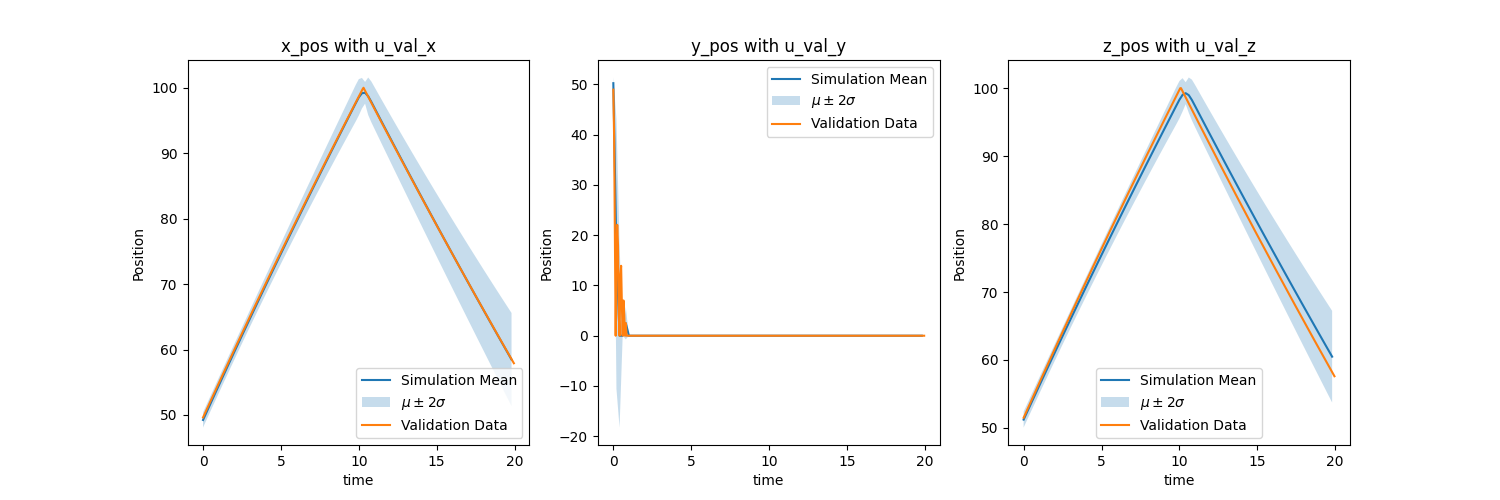

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

ax[0].plot(time_common, x_pos_mean_common)
ax[1].plot(time_common, y_pos_mean_common)
ax[2].plot(time_common, z_pos_mean_common)

ax[0].fill_between(time_common,x_pos_mean_common+2*u_val_x,x_pos_mean_common-2*u_val_x, alpha=0.25)
ax[1].fill_between(time_common,y_pos_mean_common+2*u_val_y,y_pos_mean_common-2*u_val_y, alpha=0.25)
ax[2].fill_between(time_common,z_pos_mean_common+2*u_val_z,z_pos_mean_common-2*u_val_z, alpha=0.25)

ax[0].plot(time_true, x_true)
ax[1].plot(time_true, y_true)
ax[2].plot(time_true, z_true)

ax[0].set_title("x_pos with u_val_x")
ax[1].set_title("y_pos with u_val_y")
ax[2].set_title("z_pos with u_val_z")

ax[0].set_xlabel("time")
ax[1].set_xlabel("time")
ax[2].set_xlabel("time")

ax[0].set_ylabel("Position")
ax[1].set_ylabel("Position")
ax[2].set_ylabel("Position")

ax[0].legend(labels=['Simulation Mean','$\mu \pm 2 \sigma$','Validation Data'])
ax[1].legend(labels=['Simulation Mean','$\mu \pm 2 \sigma$','Validation Data'])
ax[2].legend(labels=['Simulation Mean','$\mu \pm 2 \sigma$','Validation Data'])
fig.savefig(os.path.join(spec_root,"../05_post-process_data/images/QoIs_u_val.png"))

# Quantification of Margins and Uncertainties (QMU)

4.645798448637161 inf 5.783813506084521


/g/g20/moreno45/Projects/WEAVE/weave_demos/ball_bounce/ball_bounce_demo_venv/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
/g/g20/moreno45/Projects/WEAVE/weave_demos/ball_bounce/ball_bounce_demo_venv/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/g/g20/moreno45/Projects/WEAVE/weave_demos/ball_bounce/ball_bounce_demo_venv/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars


<IPython.core.display.Javascript object>


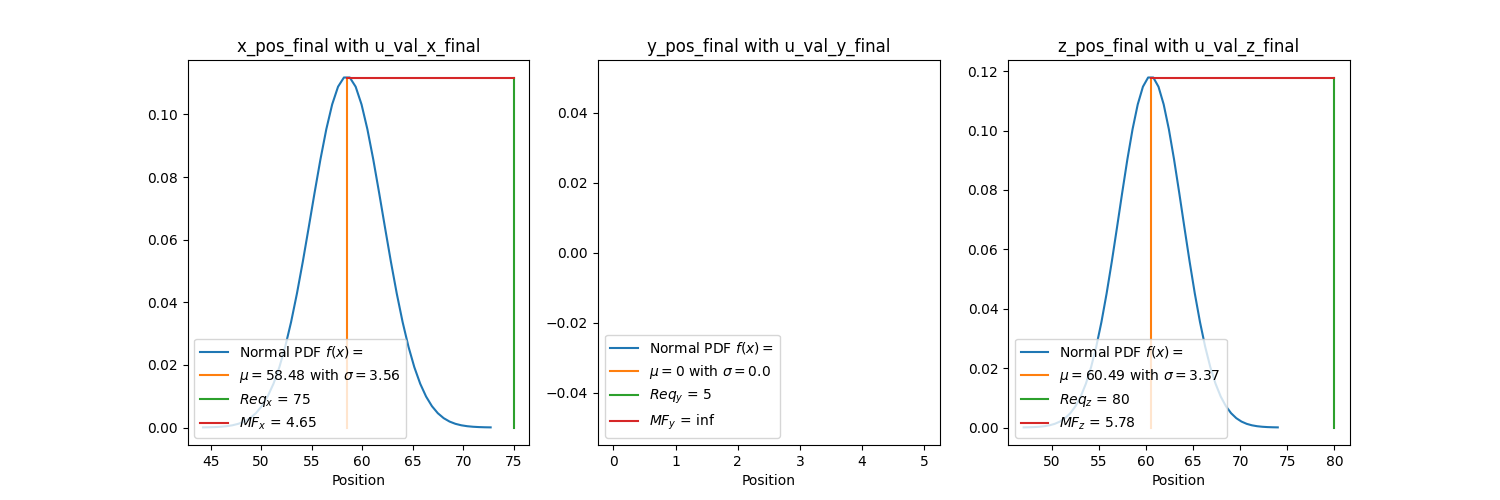

In [16]:
# Gathering Data

# Data spanning 4 standard deviations
x_list = np.linspace(x_pos_mean_common[-1]-4*u_val_x[-1],x_pos_mean_common[-1]+4*u_val_x[-1])
y_list = np.linspace(y_pos_mean_common[-1]-4*u_val_y[-1],y_pos_mean_common[-1]+4*u_val_y[-1])
z_list = np.linspace(z_pos_mean_common[-1]-4*u_val_z[-1],z_pos_mean_common[-1]+4*u_val_z[-1])

# Normal Distribution
x_dist =  1/( np.sqrt(2 * np.pi * u_val_x[-1]**2)) * np.exp( - (x_list - x_pos_mean_common[-1])**2 / (2 * u_val_x[-1]**2) )
y_dist =  1/( np.sqrt(2 * np.pi * u_val_y[-1]**2)) * np.exp( - (y_list - y_pos_mean_common[-1])**2 / (2 * u_val_y[-1]**2) )
z_dist =  1/( np.sqrt(2 * np.pi * u_val_z[-1]**2)) * np.exp( - (z_list - z_pos_mean_common[-1])**2 / (2 * u_val_z[-1]**2) )

# Requirement
Req_x = 75
Req_y = 5
Req_z = 80

# Margin Factor
MF_x = (Req_x-x_pos_mean_common[-1])/u_val_x[-1]
MF_y = (Req_y-y_pos_mean_common[-1])/u_val_y[-1]
MF_z = (Req_z-z_pos_mean_common[-1])/u_val_z[-1]

print(MF_x, MF_y, MF_z)

# Plotting

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

ax[0].plot(x_list, x_dist, label = 'Normal PDF $f(x)=\frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{x-\mu}{2\sigma^2}}$')
ax[1].plot(y_list, y_dist, label = 'Normal PDF $f(x)=\frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{x-\mu}{2\sigma^2}}$')
ax[2].plot(z_list, z_dist, label = 'Normal PDF $f(x)=\frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{x-\mu}{2\sigma^2}}$')

ax[0].plot([x_pos_mean_common[-1],x_pos_mean_common[-1]], [0, max(x_dist)], label = f'$\mu=${round(x_pos_mean_common[-1],2)} with $\sigma=${round(u_val_x[-1],2)}')
ax[1].plot([y_pos_mean_common[-1],y_pos_mean_common[-1]], [0, max(y_dist)], label = f'$\mu=${round(y_pos_mean_common[-1],2)} with $\sigma=${round(u_val_y[-1],2)}')
ax[2].plot([z_pos_mean_common[-1],z_pos_mean_common[-1]], [0, max(z_dist)], label = f'$\mu=${round(z_pos_mean_common[-1],2)} with $\sigma=${round(u_val_z[-1],2)}')

ax[0].plot([Req_x,Req_x], [0, max(x_dist)], label = f'$Req_x$ = {Req_x}')
ax[1].plot([Req_y,Req_y], [0, max(y_dist)], label = f'$Req_y$ = {Req_y}')
ax[2].plot([Req_z,Req_z], [0, max(z_dist)], label = f'$Req_z$ = {Req_z}')

ax[0].plot([x_pos_mean_common[-1],Req_x], [max(x_dist), max(x_dist)], label = f'$MF_x$ = {round(MF_x,2)}')
ax[1].plot([y_pos_mean_common[-1],Req_y], [max(y_dist), max(y_dist)], label = f'$MF_y$ = {round(MF_y,2)}')
ax[2].plot([z_pos_mean_common[-1],Req_z], [max(z_dist), max(z_dist)], label = f'$MF_z$ = {round(MF_z,2)}')

ax[0].set_title("x_pos_final with u_val_x_final")
ax[1].set_title("y_pos_final with u_val_y_final")
ax[2].set_title("z_pos_final with u_val_z_final")

ax[0].set_xlabel("Position")
ax[1].set_xlabel("Position")
ax[2].set_xlabel("Position")

ax[0].legend(loc = 'lower left')
ax[1].legend(loc = 'lower left')
ax[2].legend(loc = 'lower left')

fig.savefig(os.path.join(spec_root,"../05_post-process_data/images/QoIs_QMU.png"))